# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [10]:
import sys
sys.path.insert(0, './Utilities/')

# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install matplotlib==3.5.1 scipy==1.7.3 scikit-learn==1.0.2 pandas==1.4.2 seaborn==0.11.2
import torch
from collections import OrderedDict
import copy

import numpy as np
import matplotlib.pyplot as plt
# !pip install scipy
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        # if self.iter % 100 == 0:
        #     print(
        #         'Loss: %e, l1: %.5f, l2: %.5f' % 
        #         (
        #             loss.item(), 
        #             self.lambda_1.item(), 
        #             torch.exp(self.lambda_2.detach()).item()
        #         )
        #     )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            # if epoch % 100 == 0:
            #     print(
            #         'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
            #         (
            #             epoch, 
            #             loss.item(), 
            #             self.lambda_1.item(), 
            #             torch.exp(self.lambda_2).item()
            #         )
            #     )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X, compute_f=True):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        if not compute_f:
            u = u.detach().cpu().numpy()
            return u, None
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [6]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

Loss: 2.454879e-02, l1: 0.18560, l2: 0.00223
Loss: 1.838210e-02, l1: 0.39783, l2: 0.00315
Loss: 1.498375e-02, l1: 0.60822, l2: 0.00442
Loss: 1.197412e-02, l1: 0.66703, l2: 0.00584
Loss: 1.038476e-02, l1: 0.73374, l2: 0.00843
Loss: 7.570810e-03, l1: 0.79959, l2: 0.00987
Loss: 4.801713e-03, l1: 0.83735, l2: 0.00812
Loss: 3.065724e-03, l1: 0.87616, l2: 0.00694
Loss: 2.141729e-03, l1: 0.91554, l2: 0.00652
Loss: 1.484559e-03, l1: 0.93416, l2: 0.00586
Loss: 1.041423e-03, l1: 0.95136, l2: 0.00549
Loss: 7.523666e-04, l1: 0.95980, l2: 0.00520
Loss: 6.048305e-04, l1: 0.97175, l2: 0.00506
Loss: 4.492013e-04, l1: 0.98653, l2: 0.00468
Loss: 3.758141e-04, l1: 0.97763, l2: 0.00449
Loss: 3.128053e-04, l1: 0.98845, l2: 0.00421
Loss: 2.563458e-04, l1: 0.98799, l2: 0.00396
Loss: 2.162966e-04, l1: 0.98374, l2: 0.00382
Loss: 1.808766e-04, l1: 0.98388, l2: 0.00369
Loss: 1.447753e-04, l1: 0.98595, l2: 0.00362
Loss: 1.211685e-04, l1: 0.98618, l2: 0.00359
Loss: 1.066073e-04, l1: 0.98523, l2: 0.00355
Loss: 9.63

In [7]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.671464e-03
Error l1: 0.12473%
Error l2: 0.54101%


In [8]:
# Calculate size of model in KB
model_size = sum(p.numel() for p in model.dnn.parameters() if p.requires_grad) * 4 / (1024)  # Assuming float32
print('Model size: %.2f KB' % model_size)

Model size: 11.81 KB


In [9]:
plt.rcParams['text.usetex'] = False
def plot_weights(model):
    weight_params = [(name, param.detach().cpu().numpy()) 
                     for name, param in model.named_parameters() if 'weight' in name]
    bias_params = [(name, param.detach().cpu().numpy()) 
                   for name, param in model.named_parameters() if 'bias' in name]

    num_weights = len(weight_params)
    num_biases = len(bias_params)

    # Plot weights
    fig_w, axs_w = plt.subplots(1, num_weights, figsize=(5 * num_weights, 4))
    if num_weights == 1:
        axs_w = [axs_w]
    for ax, (name, param) in zip(axs_w, weight_params):
        ax.hist(param.flatten(), bins=50)
        ax.set_title(f'Weights: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig_w.suptitle('Weight Distributions')
    fig_w.tight_layout()

    # Plot biases
    fig_b, axs_b = plt.subplots(1, num_biases, figsize=(5 * num_biases, 4))
    if num_biases == 1:
        axs_b = [axs_b]
    for ax, (name, param) in zip(axs_b, bias_params):
        ax.hist(param.flatten(), bins=50)
        ax.set_title(f'Biases: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig_b.suptitle('Bias Distributions')
    fig_b.tight_layout()


def plot_activations(model, input_sample):
    activations = []

    def hook_fn(module, input, output):
        if isinstance(module, torch.nn.Tanh):
            activations.append(output.detach().cpu().numpy())

    # Register hooks to Tanh layers
    hooks = []
    for layer in model.layers:
        if isinstance(layer, torch.nn.Tanh):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        model(input_sample)

    # Plot activations in a grid
    num_acts = len(activations)
    fig, axs = plt.subplots(1, num_acts, figsize=(5 * num_acts, 4))
    if num_acts == 1:
        axs = [axs]
    for idx, (ax, act) in enumerate(zip(axs, activations)):
        ax.hist(act.flatten(), bins=50)
        ax.set_title(f'Tanh {idx}')
        ax.set_xlabel('Activation')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Activation Distributions (Tanh)')
    fig.tight_layout()

    # Remove hooks
    for h in hooks:
        h.remove()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


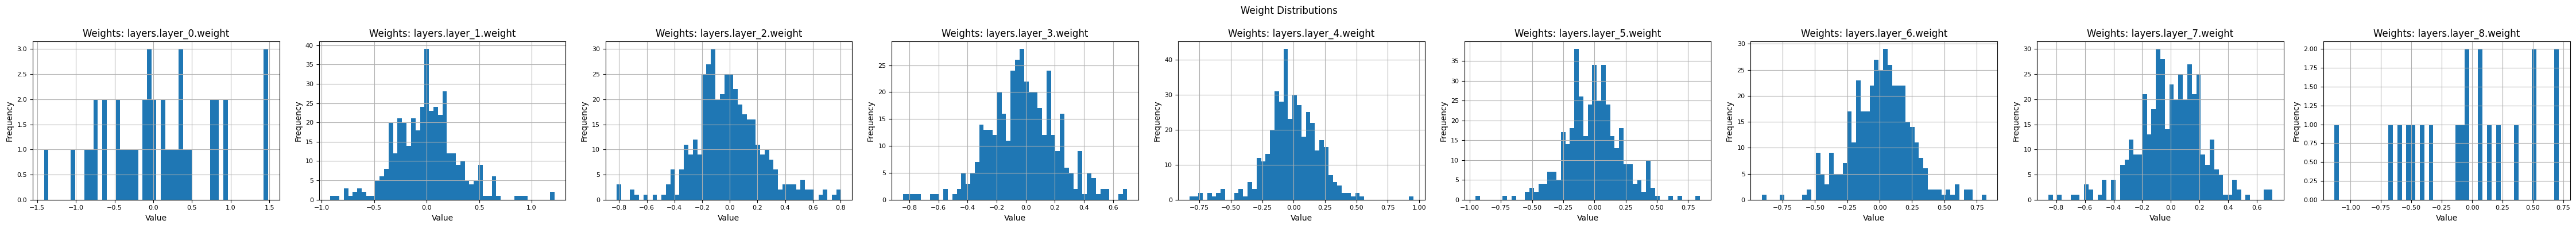

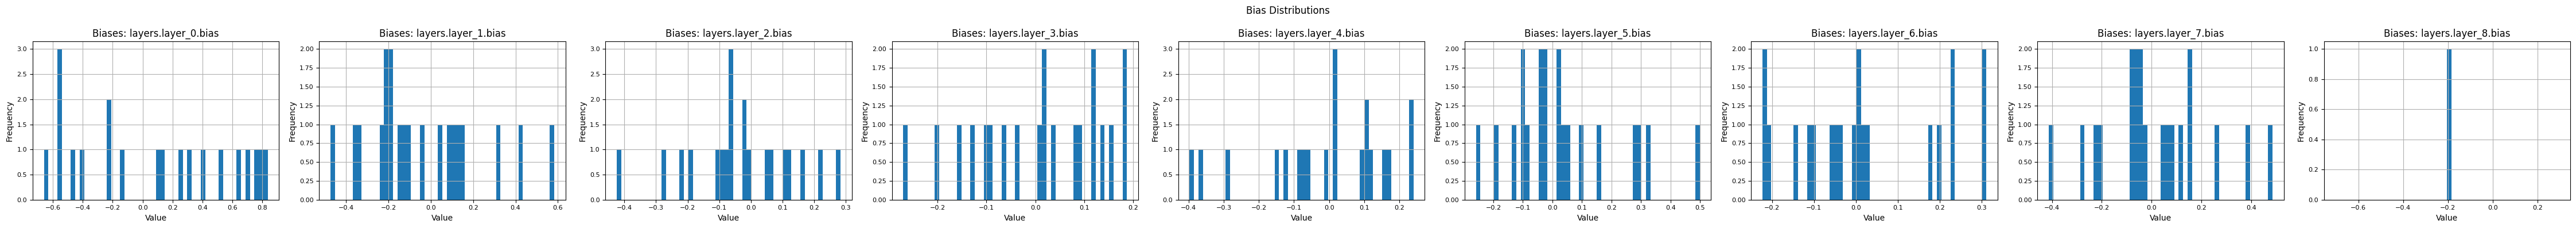

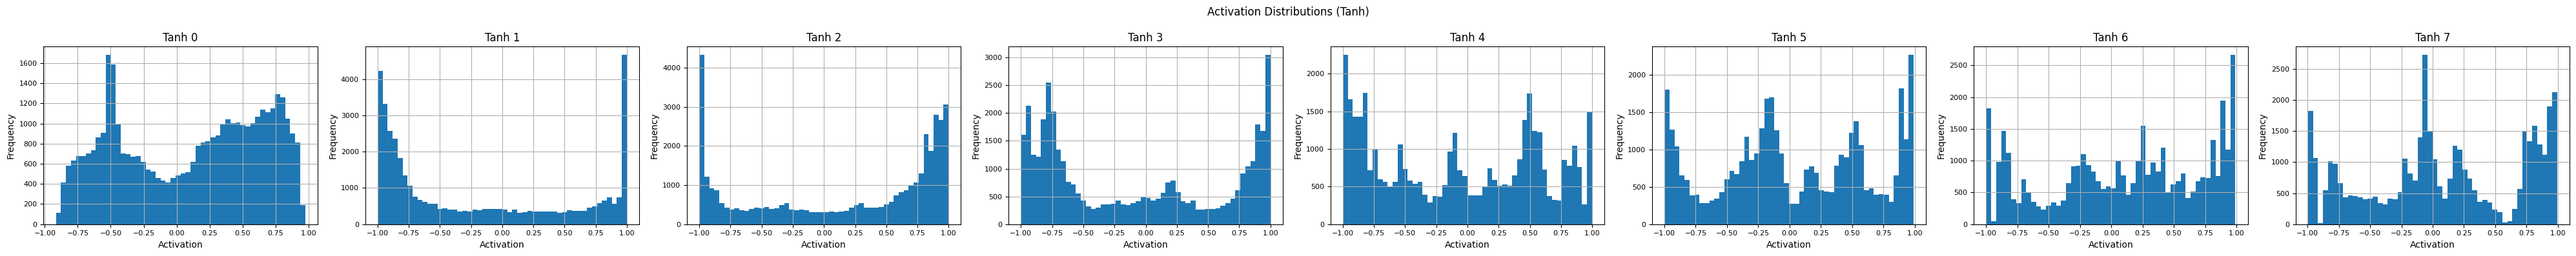

In [10]:
plot_weights(model.dnn)

# Generate sample input (you can use training data or linspace)
x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

# Visualize activations
plot_activations(model.dnn, input_sample)

## Training on Noisy Data

In [11]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)            

It: 0, Loss: 3.880e-01, Lambda_1: -0.001, Lambda_2: 0.002478


It: 100, Loss: 9.336e-02, Lambda_1: -0.013, Lambda_2: 0.002420
It: 200, Loss: 3.285e-02, Lambda_1: 0.055, Lambda_2: 0.002197
It: 300, Loss: 2.696e-02, Lambda_1: 0.100, Lambda_2: 0.002178
It: 400, Loss: 2.399e-02, Lambda_1: 0.145, Lambda_2: 0.002138
It: 500, Loss: 2.172e-02, Lambda_1: 0.188, Lambda_2: 0.002149
It: 600, Loss: 1.998e-02, Lambda_1: 0.230, Lambda_2: 0.002207
It: 700, Loss: 1.564e-02, Lambda_1: 0.297, Lambda_2: 0.002277
It: 800, Loss: 1.268e-02, Lambda_1: 0.371, Lambda_2: 0.002372
It: 900, Loss: 1.182e-02, Lambda_1: 0.410, Lambda_2: 0.002463
It: 1000, Loss: 1.013e-02, Lambda_1: 0.455, Lambda_2: 0.002531
It: 1100, Loss: 9.119e-03, Lambda_1: 0.496, Lambda_2: 0.002606
It: 1200, Loss: 8.597e-03, Lambda_1: 0.534, Lambda_2: 0.002684
It: 1300, Loss: 7.309e-03, Lambda_1: 0.562, Lambda_2: 0.002733
It: 1400, Loss: 7.751e-03, Lambda_1: 0.538, Lambda_2: 0.002780
It: 1500, Loss: 6.942e-03, Lambda_1: 0.563, Lambda_2: 0.002810
It: 1600, Loss: 6.349e-03, Lambda_1: 0.591, Lambda_2: 0.002841


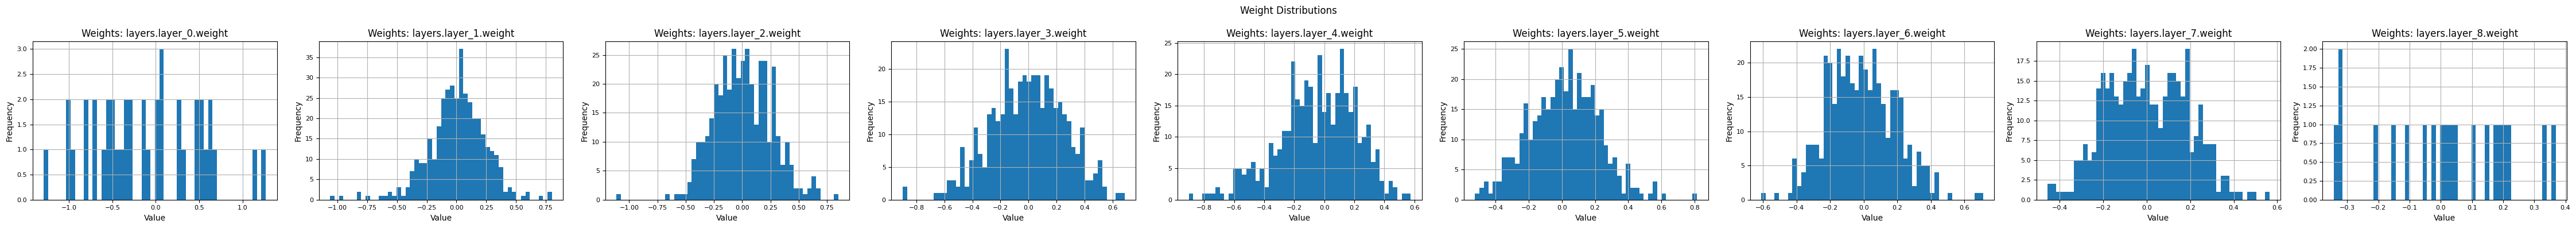

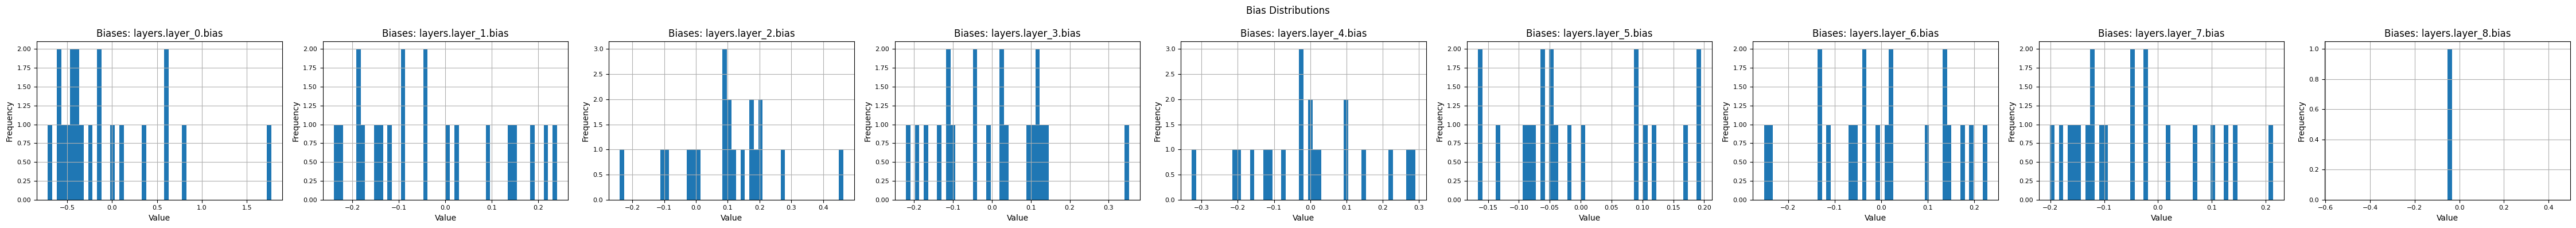

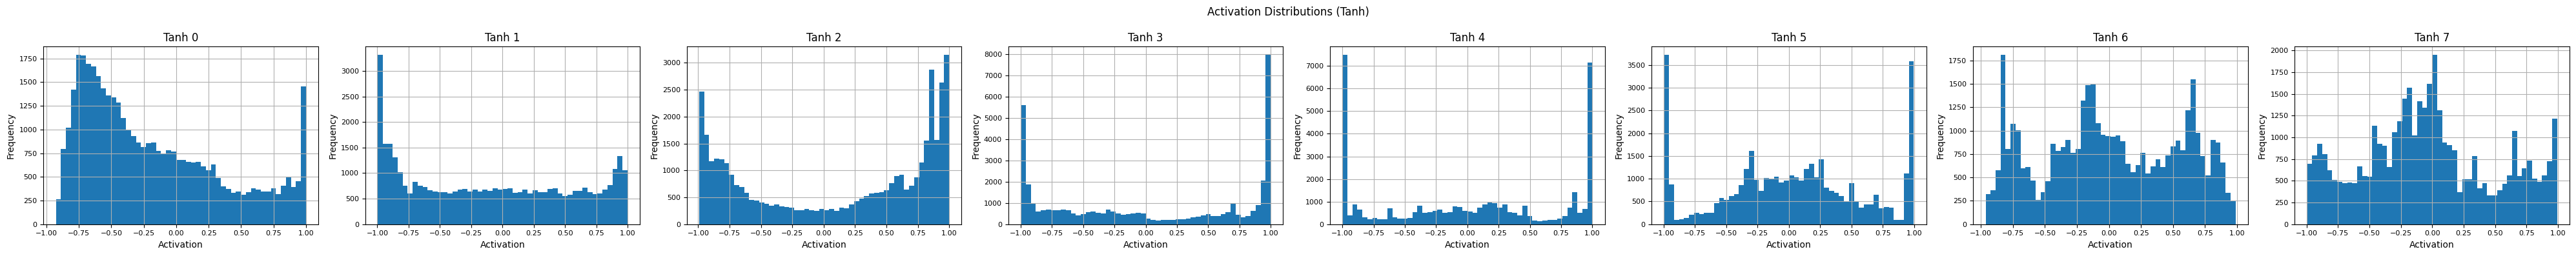

In [12]:
plot_weights(model.dnn)

# Generate sample input (you can use training data or linspace)
x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

# Visualize activations
plot_activations(model.dnn, input_sample)

## Visualizations

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


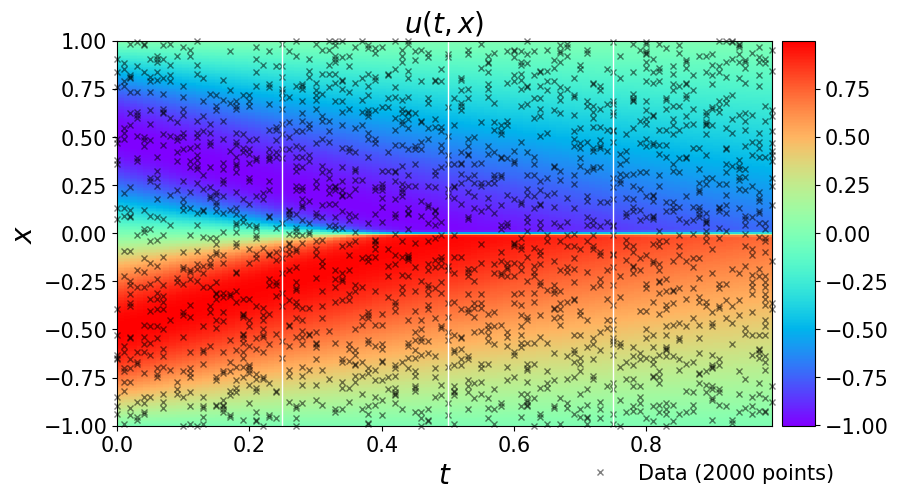

In [11]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    
plt.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

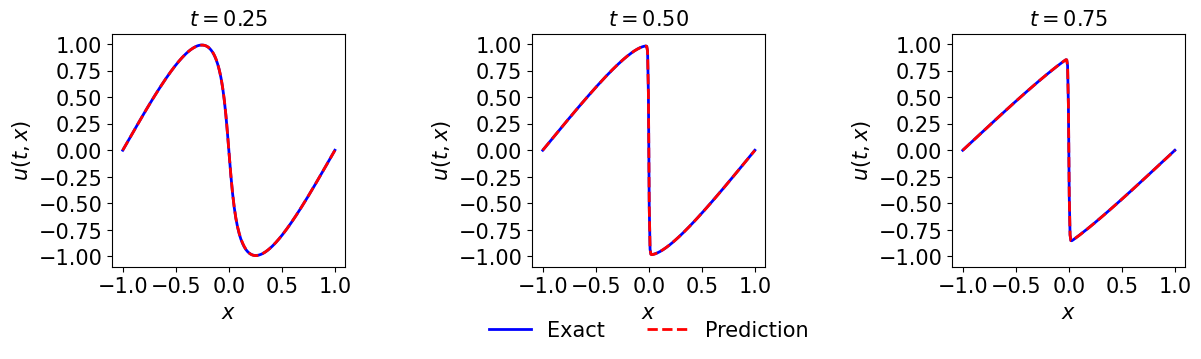

In [12]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [13]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 1.671464e-03
Error l1: 0.12473%
Error l2: 0.54101%


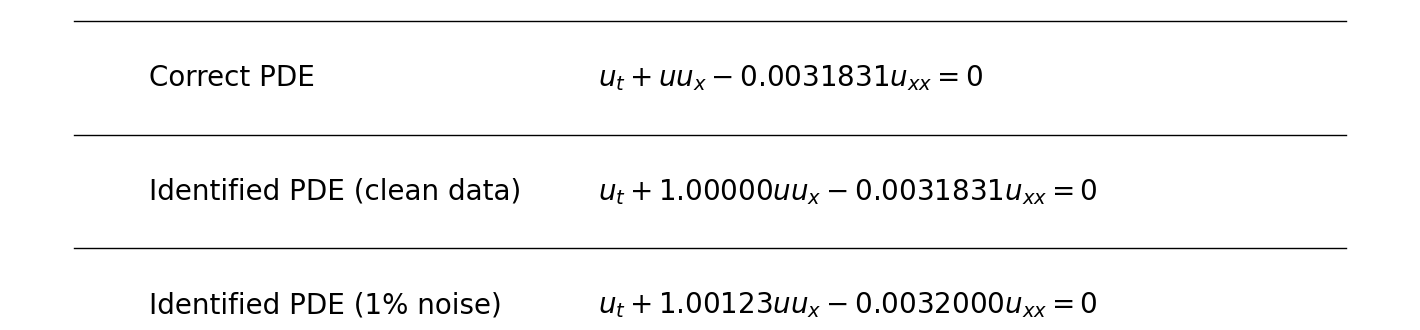

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ------------------------------------------

# Define dummy values for lambda_1_value, lambda_2_value, etc., for the code to be runnable.
# In your actual script, these would come from your calculations.
lambda_1_value = 1.00000
lambda_2_value = 0.0031831
lambda_1_value_noisy = 1.00123
lambda_2_value_noisy = 0.0032000

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

# Define base coordinates for text
base_x = 0.1
base_y = 0.75 # Start higher up, adjust as needed
line_spacing = 0.1 # Vertical spacing between lines
col_spacing = 0.3 # Horizontal spacing between columns

ax.text(base_x, base_y, 'Correct PDE', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y, '$u_t + u u_x - 0.0031831 u_{xx} = 0$', size=20, ha='left', va='center')

# Row 2 (clean data)
ax.text(base_x, base_y - line_spacing, 'Identified PDE (clean data)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value, lambda_2_value), size=20, ha='left', va='center')

# Row 3 (1% noise)
ax.text(base_x, base_y - 2 * line_spacing, 'Identified PDE (1% noise)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - 2 * line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value_noisy, lambda_2_value_noisy), size=20, ha='left', va='center')

# Optional: Add horizontal lines manually if you want the table look
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y + line_spacing/2, base_y + line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - line_spacing/2, base_y - line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - 3*line_spacing/2, base_y - 3*line_spacing/2], color='black', linewidth=1) # Added third line
plt.show()

In [ ]:
# Quantize the model (CPU only) and evaluate its error
# import torch

# Move model to CPU for quantization
quantized_model = model

# Apply dynamic quantization to Linear layers
quantized_dnn = torch.quantization.quantize_dynamic(
    model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
)

# Evaluate quantized model on CPU
quantized_model.dnn = quantized_dnn

# Make sure input is on CPU
X_star_cpu = X_star.astype(np.float32)
u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

print('Quantized model error u: %e' % (error_u_q))

Quantized model error u: 1.955070e-03


In [28]:
# Calculate size of model in KB
model_size = sum(p.numel() for p in quantized_dnn.parameters() if p.requires_grad) * 4 / (1024)  # Assuming float32
print('Model size: %.2f KB' % model_size)

Model size: 0.02 KB


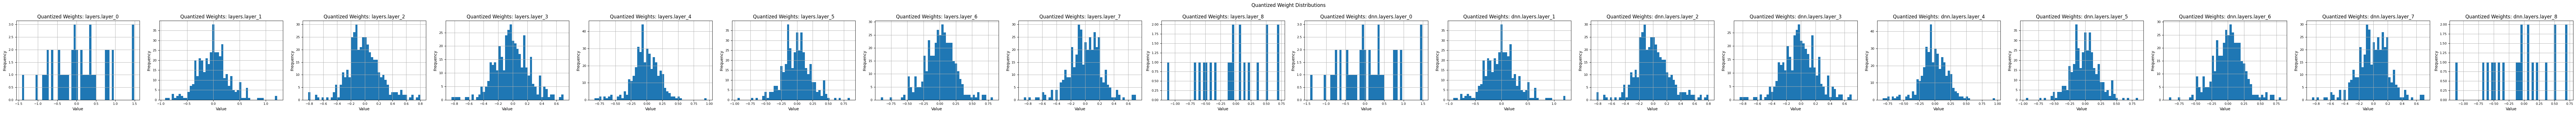

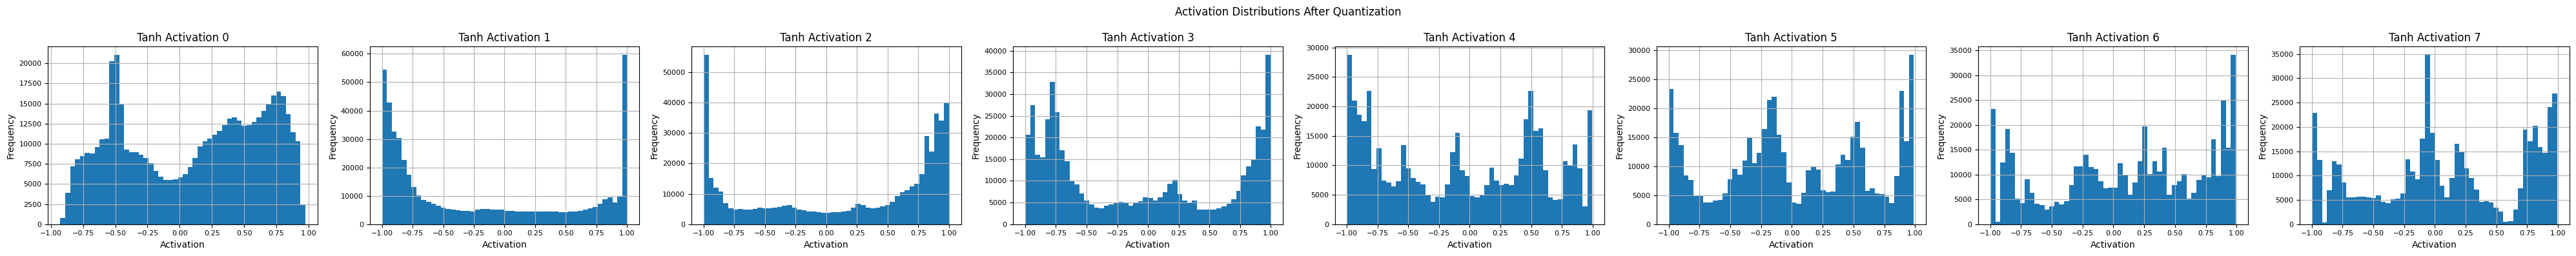

In [29]:
def plot_quantized_weights(model):
    weights = []
    names = []
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.dynamic.Linear):
            # Dequantize to float32 for plotting
            float_weight = module.weight().dequantize().cpu().numpy()
            weights.append(float_weight.flatten())
            names.append(name)
    
    # Plot all weight distributions
    fig, axs = plt.subplots(1, len(weights), figsize=(5 * len(weights), 4))
    if len(weights) == 1:
        axs = [axs]
    for ax, weight, name in zip(axs, weights, names):
        ax.hist(weight, bins=50)
        ax.set_title(f'Quantized Weights: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Quantized Weight Distributions')
    fig.tight_layout()

def plot_activations(model, input_sample):
    activations = []

    def hook_fn(module, input, output):
        if isinstance(module, torch.nn.Tanh):
            activations.append(output.detach().cpu().numpy())

    hooks = []
    for layer in model.dnn.modules():
        if isinstance(layer, torch.nn.Tanh):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Run forward pass
    with torch.no_grad():
        model.predict(input_sample.astype(np.float32), False)

    # Plot
    fig, axs = plt.subplots(1, len(activations), figsize=(5 * len(activations), 4))
    if len(activations) == 1:
        axs = [axs]
    for ax, act, idx in zip(axs, activations, range(len(activations))):
        ax.hist(act.flatten(), bins=50)
        ax.set_title(f'Tanh Activation {idx}')
        ax.set_xlabel('Activation')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Activation Distributions After Quantization')
    fig.tight_layout()

    for h in hooks:
        h.remove()

x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

plot_quantized_weights(quantized_model.dnn)
plot_activations(quantized_model, X_star_cpu)
plt.show()

# plot_weights(model.dnn)

# # Generate sample input (you can use training data or linspace)


# # Visualize activations
# plot_activations(model.dnn, input_sample)

# Results
Original Model's L2 Loss: 3.087599e-03

Quantized (qint8) Model's L2 Loss: 3.143737e-03

Quantized (float16) Model's L2 Loss: 3.143737e-03

In [ ]:
# for i in range(50):
#     print('Iteration %d' % (i+1))
#     # create training set
#     idx = np.random.choice(X_star.shape[0], N_u, replace=False)
#     X_u_train = X_star[idx,:]
#     u_train = u_star[idx,:]

#     # training vanilla PINN
#     model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
#     model.train(0)

#     u_pred, f_pred = model.predict(X_star)

#     error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#     print('Error u: %e' % (error_u))    


#     # quantized
#     quantized_model = model

#     # Apply dynamic quantization to Linear layers
#     quantized_dnn = torch.quantization.quantize_dynamic(
#         model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
#     )

#     # Evaluate quantized model on CPU
#     quantized_model.dnn = quantized_dnn

#     # Make sure input is on CPU
#     X_star_cpu = X_star.astype(np.float32)
#     u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

#     error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

#     print('Quantized model error u: %e' % (error_u_q))

errors = [ # Base Model Error, Quantized Model Error
    [1.388958e-03, 1.510060e-03],
    [3.309782e-03, 3.512879e-03],
    [1.144552e-03, 1.680257e-03],
    [3.983787e-03, 4.174176e-03],
    [1.243632e-03, 1.824453e-03],
    [2.943262e-03, 3.107932e-03],
    [1.052625e-03, 1.176445e-03],
    [8.139572e-03, 8.310566e-03],
    [1.804898e-03, 3.197283e-03],
    [1.961823e-03, 2.918181e-03],
    [2.849114e-03, 3.000468e-03],
    [3.897179e-03, 4.223944e-03],
    [3.100605e-03, 3.743086e-03],
    [5.139509e-03, 5.191253e-03],
    [1.504057e-03, 1.422136e-03],
    [1.113949e-03, 1.438476e-03],
    [1.819771e-03, 1.937835e-03],
    [2.472424e-03, 2.847346e-03],
    [2.992785e-03, 3.938630e-03],
    [3.988617e-03, 4.480300e-03],
    [1.923000e-03, 2.179773e-03],
    [1.891441e-03, 2.412488e-03],
    [2.329319e-02, 2.326551e-02],
    [3.130236e-03, 3.341197e-03],
    [3.854241e-03, 3.858712e-03],
    [1.769644e-03, 1.725584e-03],
    [1.663422e-03, 2.152327e-03],
    [7.786678e-03, 1.006356e-02],
    [1.047162e-03, 1.342936e-03],
    [4.684336e-03, 4.917040e-03],
    [1.303013e-03, 1.536873e-03],
    [1.094588e-02, 1.102945e-02],
    [3.979636e-03, 5.575185e-03],
    [1.371120e-03, 2.049382e-03],
    [1.072179e-03, 1.486318e-03],
    [4.007025e-03, 3.967564e-03],
    [7.907806e-03, 8.158320e-03],
    [4.141092e-03, 4.827751e-03],
    [1.374554e-03, 1.683193e-03],
    [2.177494e-03, 2.485343e-03],
    [2.562515e-03, 3.290203e-03],
    [4.339867e-03, 5.203859e-03],
    [1.350818e-03, 1.493116e-03],
    [5.247001e-03, 5.442823e-03],
    [2.577730e-03, 2.886398e-03],
    [6.408195e-03, 6.754097e-03],
    [1.894262e-01, 1.894304e-01],
    [4.054336e-03, 4.454140e-03],
    [3.424505e-03, 3.257452e-03],
    [3.273438e-03, 3.923809e-03]
]


Iteration 1


KeyboardInterrupt: 

Iteration 1
Error u: 1.388958e-03
Quantized model error u: 1.510060e-03
Iteration 2
Error u: 3.309782e-03
Quantized model error u: 3.512879e-03
Iteration 3
Error u: 1.144552e-03
Quantized model error u: 1.680257e-03
Iteration 4
Error u: 3.983787e-03
Quantized model error u: 4.174176e-03
Iteration 5
Error u: 1.243632e-03
Quantized model error u: 1.824453e-03
Iteration 6
Error u: 2.943262e-03
Quantized model error u: 3.107932e-03
Iteration 7
Error u: 1.052625e-03
Quantized model error u: 1.176445e-03
Iteration 8
Error u: 8.139572e-03
Quantized model error u: 8.310566e-03
Iteration 9
Error u: 1.804898e-03
Quantized model error u: 3.197283e-03
Iteration 10
Error u: 1.961823e-03
Quantized model error u: 2.918181e-03
Iteration 11
Error u: 2.849114e-03
Quantized model error u: 3.000468e-03
Iteration 12
Error u: 3.897179e-03
Quantized model error u: 4.223944e-03
Iteration 13
Error u: 3.100605e-03
Quantized model error u: 3.743086e-03
Iteration 14
Error u: 5.139509e-03
Quantized model error u: 5.191253e-03
Iteration 15
Error u: 1.504057e-03
Quantized model error u: 1.422136e-03
Iteration 16
Error u: 1.113949e-03
Quantized model error u: 1.438476e-03
Iteration 17
Error u: 1.819771e-03
Quantized model error u: 1.937835e-03
Iteration 18
Error u: 2.472424e-03
Quantized model error u: 2.847346e-03
Iteration 19
Error u: 2.992785e-03
Quantized model error u: 3.938630e-03
Iteration 20
Error u: 3.988617e-03
Quantized model error u: 4.480300e-03
Iteration 21
Error u: 1.923000e-03
Quantized model error u: 2.179773e-03
Iteration 22
Error u: 1.891441e-03
Quantized model error u: 2.412488e-03
Iteration 23
Error u: 2.329319e-02
Quantized model error u: 2.326551e-02
Iteration 24
Error u: 3.130236e-03
Quantized model error u: 3.341197e-03
Iteration 25
Error u: 3.854241e-03
Quantized model error u: 3.858712e-03
Iteration 26
Error u: 1.769644e-03
Quantized model error u: 1.725584e-03
Iteration 27
Error u: 1.663422e-03
Quantized model error u: 2.152327e-03
Iteration 28
Error u: 7.786678e-03
Quantized model error u: 1.006356e-02
Iteration 29
Error u: 1.047162e-03
Quantized model error u: 1.342936e-03
Iteration 30
Error u: 4.684336e-03
Quantized model error u: 4.917040e-03
Iteration 31
Error u: 1.303013e-03
Quantized model error u: 1.536873e-03
Iteration 32
Error u: 1.094588e-02
Quantized model error u: 1.102945e-02
Iteration 33
Error u: 3.979636e-03
Quantized model error u: 5.575185e-03
Iteration 34
Error u: 1.371120e-03
Quantized model error u: 2.049382e-03
Iteration 35
Error u: 1.072179e-03
Quantized model error u: 1.486318e-03
Iteration 36
Error u: 4.007025e-03
Quantized model error u: 3.967564e-03
Iteration 37
Error u: 7.907806e-03
Quantized model error u: 8.158320e-03
Iteration 38
Error u: 4.141092e-03
Quantized model error u: 4.827751e-03
Iteration 39
Error u: 1.374554e-03
Quantized model error u: 1.683193e-03
Iteration 40
Error u: 2.177494e-03
Quantized model error u: 2.485343e-03
Iteration 41
Error u: 2.562515e-03
Quantized model error u: 3.290203e-03
Iteration 42
Error u: 4.339867e-03
Quantized model error u: 5.203859e-03
Iteration 43
Error u: 1.350818e-03
Quantized model error u: 1.493116e-03
Iteration 44
Error u: 5.247001e-03
Quantized model error u: 5.442823e-03
Iteration 45
Error u: 2.577730e-03
Quantized model error u: 2.886398e-03
Iteration 46
Error u: 6.408195e-03
Quantized model error u: 6.754097e-03
Iteration 47
Error u: 1.894262e-01
Quantized model error u: 1.894304e-01
Iteration 48
Error u: 4.054336e-03
Quantized model error u: 4.454140e-03
Iteration 49
Error u: 3.424505e-03
Quantized model error u: 3.257452e-03
Iteration 50
Error u: 3.273438e-03
Quantized model error u: 3.923809e-03

In [ ]:
# for i in range(50):
#     print('Iteration %d' % (i+1))
#     # create training set
#     idx = np.random.choice(X_star.shape[0], N_u, replace=False)
#     X_u_train = X_star[idx,:]
#     u_train = u_star[idx,:]

#     noise = 0.01    

#     # create training set
#     u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

#     # training
#     model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
#     model.train(10000)  

#     # # training vanilla PINN
#     # model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
#     # model.train(0)

#     u_pred, f_pred = model.predict(X_star)

#     error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#     print('Error u: %e' % (error_u))    


#     # quantized
#     quantized_model = model

#     # Apply dynamic quantization to Linear layers
#     quantized_dnn = torch.quantization.quantize_dynamic(
#         model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
#     )

#     # Evaluate quantized model on CPU
#     quantized_model.dnn = quantized_dnn

#     # Make sure input is on CPU
#     X_star_cpu = X_star.astype(np.float32)
#     u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

#     error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

#     print('Quantized model error u: %e' % (error_u_q))

error_u = [
    1.441395e-03, 2.087841e-03, 2.030207e-03, 3.753681e-03, 1.625797e-03,
    1.828460e-03, 1.254899e-03, 1.797645e-03, 1.735009e-03, 3.279133e-03,
    1.460087e-03, 1.622986e-03, 1.614485e-03, 1.878116e-03, 1.686775e-03,
    1.306080e-03, 1.415755e-03, 2.324572e-03, 3.478710e-03, 1.774508e-03,
    1.554093e-03, 1.984878e-03, 1.191317e-03, 1.730447e-03, 2.509339e-03,
    1.682525e-03, 1.816406e-03, 1.548586e-03, 1.837531e-03, 1.948161e-03
]

quantized_error_u = [
    1.346318e-03, 2.090569e-03, 2.016114e-03, 3.591259e-03, 1.993442e-03,
    1.958678e-03, 1.256398e-03, 1.782304e-03, 1.755228e-03, 3.317686e-03,
    1.515790e-03, 1.604831e-03, 1.529921e-03, 1.979754e-03, 1.796817e-03,
    1.401216e-03, 1.561155e-03, 2.420682e-03, 3.429215e-03, 1.735413e-03,
    1.541942e-03, 2.102076e-03, 1.623987e-03, 1.858646e-03, 2.551402e-03,
    1.837547e-03, 1.965355e-03, 1.580542e-03, 2.073917e-03, 2.001293e-03
]

# Create a 2xN NumPy array
errors_2xN = np.array([error_u, quantized_error_u])


Iteration 1
Error u: 1.441395e-03
Quantized model error u: 1.346318e-03
Iteration 2
Error u: 2.087841e-03
Quantized model error u: 2.090569e-03
Iteration 3
Error u: 2.030207e-03
Quantized model error u: 2.016114e-03
Iteration 4
Error u: 3.753681e-03
Quantized model error u: 3.591259e-03
Iteration 5
Error u: 1.625797e-03
Quantized model error u: 1.993442e-03
Iteration 6
Error u: 1.828460e-03
Quantized model error u: 1.958678e-03
Iteration 7
Error u: 1.254899e-03
Quantized model error u: 1.256398e-03
Iteration 8
Error u: 1.797645e-03
Quantized model error u: 1.782304e-03
Iteration 9
Error u: 1.735009e-03
Quantized model error u: 1.755228e-03
Iteration 10
Error u: 3.279133e-03
Quantized model error u: 3.317686e-03
Iteration 11
Error u: 1.460087e-03
Quantized model error u: 1.515790e-03
Iteration 12
Error u: 1.622986e-03
Quantized model error u: 1.604831e-03
Iteration 13
Error u: 1.614485e-03
Quantized model error u: 1.529921e-03
Iteration 14
Error u: 1.878116e-03
Quantized model error u: 

Iteration 1
Error u: 1.441395e-03
Quantized model error u: 1.346318e-03
Iteration 2
Error u: 2.087841e-03
Quantized model error u: 2.090569e-03
Iteration 3
Error u: 2.030207e-03
Quantized model error u: 2.016114e-03
Iteration 4
Error u: 3.753681e-03
Quantized model error u: 3.591259e-03
Iteration 5
Error u: 1.625797e-03
Quantized model error u: 1.993442e-03
Iteration 6
Error u: 1.828460e-03
Quantized model error u: 1.958678e-03
Iteration 7
Error u: 1.254899e-03
Quantized model error u: 1.256398e-03
Iteration 8
Error u: 1.797645e-03
Quantized model error u: 1.782304e-03
Iteration 9
Error u: 1.735009e-03
Quantized model error u: 1.755228e-03
Iteration 10
Error u: 3.279133e-03
Quantized model error u: 3.317686e-03
Iteration 11
Error u: 1.460087e-03
Quantized model error u: 1.515790e-03
Iteration 12
Error u: 1.622986e-03
Quantized model error u: 1.604831e-03
Iteration 13
Error u: 1.614485e-03
Quantized model error u: 1.529921e-03
Iteration 14
Error u: 1.878116e-03
Quantized model error u: 1.979754e-03
Iteration 15
Error u: 1.686775e-03
Quantized model error u: 1.796817e-03
Iteration 16
Error u: 1.306080e-03
Quantized model error u: 1.401216e-03
Iteration 17
Error u: 1.415755e-03
Quantized model error u: 1.561155e-03
Iteration 18
Error u: 2.324572e-03
Quantized model error u: 2.420682e-03
Iteration 19
Error u: 3.478710e-03
Quantized model error u: 3.429215e-03
Iteration 20
Error u: 1.774508e-03
Quantized model error u: 1.735413e-03
Iteration 21
Error u: 1.554093e-03
Quantized model error u: 1.541942e-03
Iteration 22
Error u: 1.984878e-03
Quantized model error u: 2.102076e-03
Iteration 23
Error u: 1.191317e-03
Quantized model error u: 1.623987e-03
Iteration 24
Error u: 1.730447e-03
Quantized model error u: 1.858646e-03
Iteration 25
Error u: 2.509339e-03
Quantized model error u: 2.551402e-03
Iteration 26
Error u: 1.682525e-03
Quantized model error u: 1.837547e-03
Iteration 27
Error u: 1.816406e-03
Quantized model error u: 1.965355e-03
Iteration 28
Error u: 1.548586e-03
Quantized model error u: 1.580542e-03
Iteration 29
Error u: 1.837531e-03
Quantized model error u: 2.073917e-03
Iteration 30
Error u: 1.948161e-03
Quantized model error u: 2.001293e-03
Iteration 31

In [6]:
for i in range(50):
    print('Iteration %d' % (i+1))
    # create training set
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    noise = 0.05   

    # create training set
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

    # training
    model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
    model.train(10000)  

    # # training vanilla PINN
    # model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
    # model.train(0)

    u_pred, f_pred = model.predict(X_star)

    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))    


    # quantized
    quantized_model = model

    # Apply dynamic quantization to Linear layers
    quantized_dnn = torch.quantization.quantize_dynamic(
        model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
    )

    # Evaluate quantized model on CPU
    quantized_model.dnn = quantized_dnn

    # Make sure input is on CPU
    X_star_cpu = X_star.astype(np.float32)
    u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

    error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

    print('Quantized model error u: %e' % (error_u_q))


Iteration 1
Error u: 5.251790e-03
Quantized model error u: 5.190169e-03
Iteration 2
Error u: 6.139549e-03
Quantized model error u: 6.235376e-03
Iteration 3
Error u: 5.542845e-03
Quantized model error u: 5.306346e-03
Iteration 4
Error u: 7.094426e-03
Quantized model error u: 7.266504e-03
Iteration 5
Error u: 4.548335e-03
Quantized model error u: 4.596479e-03
Iteration 6
Error u: 5.865885e-03
Quantized model error u: 5.857538e-03
Iteration 7
Error u: 4.650124e-03
Quantized model error u: 4.698164e-03
Iteration 8
Error u: 5.864496e-03
Quantized model error u: 5.835944e-03
Iteration 9
Error u: 5.976812e-03
Quantized model error u: 6.112630e-03
Iteration 10
Error u: 5.577872e-03
Quantized model error u: 5.810761e-03
Iteration 11
Error u: 5.569908e-03
Quantized model error u: 5.698638e-03
Iteration 12
Error u: 5.425568e-03
Quantized model error u: 5.823907e-03
Iteration 13
Error u: 6.663916e-03
Quantized model error u: 6.709024e-03
Iteration 14
Error u: 5.201711e-03
Quantized model error u: 

KeyboardInterrupt: 

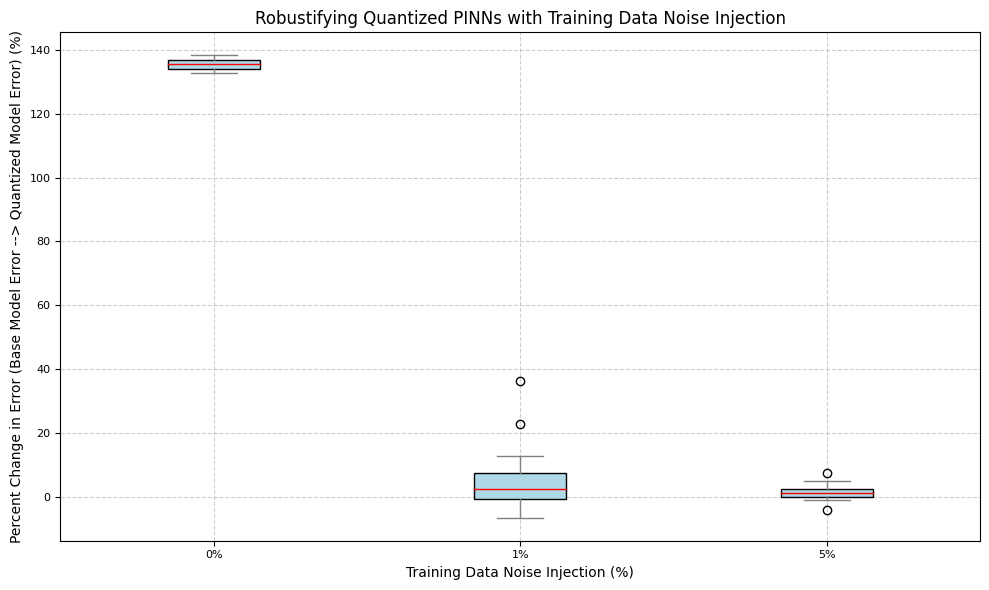

In [19]:
error_u = [
    1.441395e-03, 2.087841e-03, 2.030207e-03, 3.753681e-03, 1.625797e-03,
    1.828460e-03, 1.254899e-03, 1.797645e-03, 1.735009e-03, 3.279133e-03,
    1.460087e-03, 1.622986e-03, 1.614485e-03, 1.878116e-03, 1.686775e-03,
    1.306080e-03, 1.415755e-03, 2.324572e-03, 3.478710e-03, 1.774508e-03,
    1.554093e-03, 1.984878e-03, 1.191317e-03, 1.730447e-03, 2.509339e-03,
    1.682525e-03, 1.816406e-03, 1.548586e-03, 1.837531e-03, 1.948161e-03
]

quantized_error_u = [
    1.346318e-03, 2.090569e-03, 2.016114e-03, 3.591259e-03, 1.993442e-03,
    1.958678e-03, 1.256398e-03, 1.782304e-03, 1.755228e-03, 3.317686e-03,
    1.515790e-03, 1.604831e-03, 1.529921e-03, 1.979754e-03, 1.796817e-03,
    1.401216e-03, 1.561155e-03, 2.420682e-03, 3.429215e-03, 1.735413e-03,
    1.541942e-03, 2.102076e-03, 1.623987e-03, 1.858646e-03, 2.551402e-03,
    1.837547e-03, 1.965355e-03, 1.580542e-03, 2.073917e-03, 2.001293e-03
]

base_00 = np.array([ # Base Model Error, Quantized Model Error
    [1.388958e-03, 1.510060e-03],
    [3.309782e-03, 3.512879e-03],
    [1.144552e-03, 1.680257e-03],
    [3.983787e-03, 4.174176e-03],
    [1.243632e-03, 1.824453e-03],
    [2.943262e-03, 3.107932e-03],
    [1.052625e-03, 1.176445e-03],
    [8.139572e-03, 8.310566e-03],
    [1.804898e-03, 3.197283e-03],
    [1.961823e-03, 2.918181e-03],
    [2.849114e-03, 3.000468e-03],
    [3.897179e-03, 4.223944e-03],
    [3.100605e-03, 3.743086e-03],
    [5.139509e-03, 5.191253e-03],
    [1.504057e-03, 1.422136e-03],
    [1.113949e-03, 1.438476e-03],
    [1.819771e-03, 1.937835e-03],
    [2.472424e-03, 2.847346e-03],
    [2.992785e-03, 3.938630e-03],
    [3.988617e-03, 4.480300e-03],
    [1.923000e-03, 2.179773e-03],
    [1.891441e-03, 2.412488e-03],
    [2.329319e-02, 2.326551e-02],
    [3.130236e-03, 3.341197e-03],
    [3.854241e-03, 3.858712e-03],
    [1.769644e-03, 1.725584e-03],
    [1.663422e-03, 2.152327e-03],
    [7.786678e-03, 1.006356e-02],
    [1.047162e-03, 1.342936e-03],
    [4.684336e-03, 4.917040e-03],
    [1.303013e-03, 1.536873e-03],
    [1.094588e-02, 1.102945e-02],
    [3.979636e-03, 5.575185e-03],
    [1.371120e-03, 2.049382e-03],
    [1.072179e-03, 1.486318e-03],
    [4.007025e-03, 3.967564e-03],
    [7.907806e-03, 8.158320e-03],
    [4.141092e-03, 4.827751e-03],
    [1.374554e-03, 1.683193e-03],
    [2.177494e-03, 2.485343e-03],
    [2.562515e-03, 3.290203e-03],
    [4.339867e-03, 5.203859e-03],
    [1.350818e-03, 1.493116e-03],
    [5.247001e-03, 5.442823e-03],
    [2.577730e-03, 2.886398e-03],
    [6.408195e-03, 6.754097e-03],
    [1.894262e-01, 1.894304e-01],
    [4.054336e-03, 4.454140e-03],
    [3.424505e-03, 3.257452e-03],
    [3.273438e-03, 3.923809e-03]
])

# Create a 2xN NumPy array
data_01 = np.array([error_u, quantized_error_u])

data_05 = np.array([
    [5.251790e-03, 5.190169e-03],
    [6.139549e-03, 6.235376e-03],
    [5.542845e-03, 5.306346e-03],
    [7.094426e-03, 7.266504e-03],
    [4.548335e-03, 4.596479e-03],
    [5.865885e-03, 5.857538e-03],
    [4.650124e-03, 4.698164e-03],
    [5.864496e-03, 5.835944e-03],
    [5.976812e-03, 6.112630e-03],
    [5.577872e-03, 5.810761e-03],
    [5.569908e-03, 5.698638e-03],
    [5.425568e-03, 5.823907e-03],
    [6.663916e-03, 6.709024e-03],
    [5.201711e-03, 5.463214e-03],
    [5.276498e-03, 5.309964e-03],
    [6.093058e-03, 6.261346e-03],
    [6.696140e-03, 6.789144e-03],
    [5.466779e-03, 5.419738e-03],
    [6.222588e-03, 6.298164e-03],
    [6.616329e-03, 6.846330e-03],
    [6.458094e-03, 6.466216e-03],
    [6.354047e-03, 6.652473e-03],
    [5.097525e-03, 5.083517e-03],
    [5.139979e-03, 5.183786e-03],
    [6.373065e-03, 6.394469e-03],
    [4.307815e-03, 4.282043e-03]
]).T 

def percent_change(arr):
    base = arr[0]
    quant = arr[1]
    return 100 * (quant - base) / base


# Calculate percent changes
pct_base_00 = percent_change(base_00)
pct_data_01 = percent_change(data_01)
pct_data_05 = percent_change(data_05)


mpl.rcParams['text.usetex'] = False
# Plot box-and-whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [pct_base_00, pct_data_01, pct_data_05],
    labels=['0%', '1%', '5%'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)
plt.ylabel("Percent Change in Error (Base Model Error --> Quantized Model Error) (%)")
plt.xlabel("Training Data Noise Injection (%)")
plt.title("Robustifying Quantized PINNs with Training Data Noise Injection")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

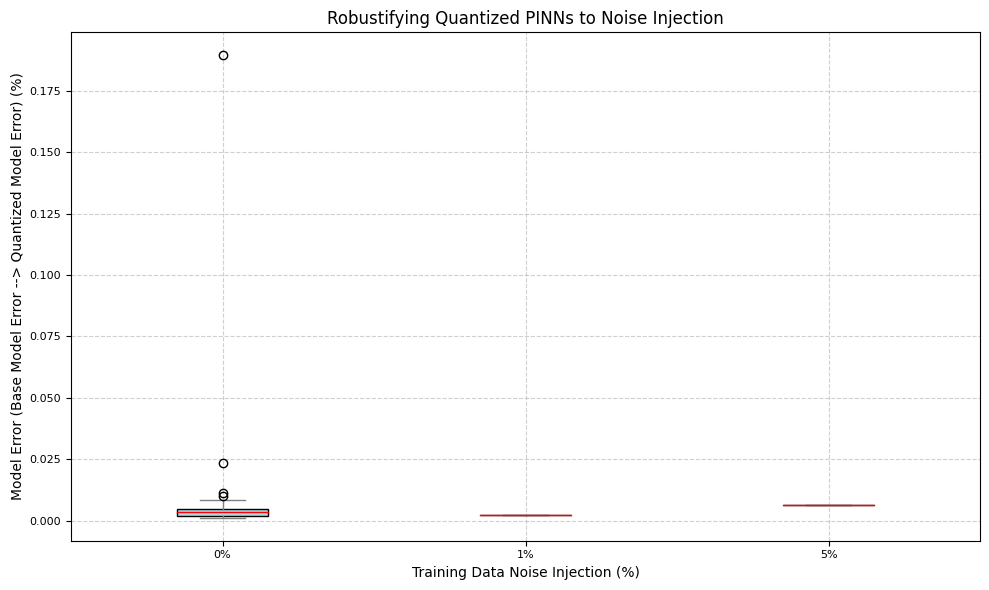

In [20]:
pct_base_00 = (base_00.T)[1]
pct_data_01 = (data_01.T)[1]
pct_data_05 = (data_05.T)[1]

# Plot box-and-whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [pct_base_00, pct_data_01, pct_data_05],
    labels=['0%', '1%', '5%'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)
plt.ylabel("Model Error (Base Model Error --> Quantized Model Error) (%)")
plt.xlabel("Training Data Noise Injection (%)")
plt.title("Robustifying Quantized PINNs to Noise Injection")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()